In [1]:
import mpramnist
from mpramnist.StarrSeq.dataset import StarrSeqDataset

from mpramnist.models import Simple_Classification_Net, Simple_Classification_for_binary_Net
from mpramnist.trainers import LitModel_StarrSeq, LitModel_StarrSeqBinary

from mpramnist import transforms as t
from mpramnist import target_transforms as t_t

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import pytorch_lightning as L
from torch.nn import functional as F

In [2]:
import sklearn
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt
def plotting_PR_AUC(seq_model, loader):
    act = nn.Sigmoid()
    #get predicted values
    y_preds = trainer.predict(seq_model, dataloaders=loader)
    y_preds = torch.concat(y_preds).cpu().numpy()
    y_preds = torch.tensor(y_preds).squeeze()
    #get target values
    targets = []
    for i, batch in enumerate(loader):
        x, y = batch
        targets.append(y)
    targets = torch.tensor(torch.concat(targets).cpu().numpy())
    y_preds = act(y_preds)
    
    threshold = 0.5 
    y_true = targets.numpy()
    y_pred = (y_preds.numpy() >= threshold).astype(int)
    y_scores = y_preds.numpy()
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    prauc = average_precision_score(y_true, y_scores)
    
    print(f"Precision (при пороге {threshold}): {precision:.2f}")
    print(f"Recall (при пороге {threshold}): {recall:.2f}")
    print(f"PR-AUC (correct): {prauc:.2f}")
    
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_scores)
    
    pr_auc = auc(recall_vals, precision_vals)
    
    print(f"PR-AUC: {pr_auc:.2f}")
    
    plt.figure(figsize=(4,3))
    plt.plot(recall_vals, precision_vals, label=f'PR Curve (AUC = {pr_auc:.2f})', linewidth=2)
    plt.xlabel('Recall', fontsize=6)
    plt.ylabel('Precision', fontsize=6)
    plt.title('Precision-Recall Curve', fontsize=7)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Tasks

In [3]:
tasks = ["RandomEnhancer",           # 0
          "GenomicPromoter",         # 1
          "CapturePromoter",         # 2
          
          "GenomicEnhancer",         # 3
          "AtacSeq",                 # 4
          
          "differentialExpression",  # 5

          "Binary"                   # 6
         ]

# Random Enhancer

In [ ]:
BATCH_SIZE = 1024
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])
task = "RandomEnhancer"
train_dataset = StarrSeqDataset(task = task, split = "train",transform = train_transform)

val_dataset = StarrSeqDataset(task = task, split = "val",transform = val_test_transform) 

test_dataset = StarrSeqDataset(task = task, split = "test", transform = val_test_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [5]:
test_dataset

Dataset StarrSeqDataset of size 3309387 (MpraDaraset)
    Number of datapoints: 3309387
    Used split fold: test

In [6]:
seq_len = len(train_dataset[0][0][0])
model = Simple_Classification_Net(seq_len = seq_len)

seq_model = LitModel_StarrSeq(model = model,
                           loss = torch.nn.BCEWithLogitsLoss(),
                           weight_decay = 1e-1, lr = 1e-2, print_each = 5)

In [4]:
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=1,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [4]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


NameError: name 'seq_model' is not defined

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.69
Recall (при пороге 0.5): 0.04
PR-AUC (correct): 0.55
PR-AUC: 0.55


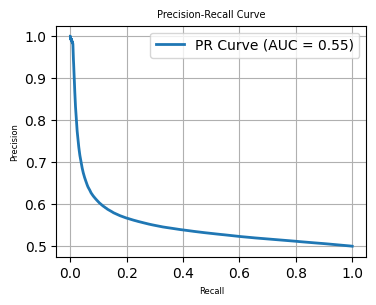

In [8]:
plotting_PR_AUC(seq_model, test_loader)

# Genomic promoter

In [9]:
BATCH_SIZE = 128
NUM_WORKERS = 103

In [10]:
train_transform = t.Compose([
    t.Seq2Tensor(),
    t.ReverseComplement(0.5)
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])

In [11]:
task = "genomicpromoter"
train_dataset = StarrSeqDataset(task = task, split = "train",transform = train_transform)

val_dataset = StarrSeqDataset(task = task, split = "val",transform = val_test_transform) 

test_dataset = StarrSeqDataset(task = task, split = "test", transform = val_test_transform)

/home/nios/5Term/mpramnist/StarrSeq/dataset.py:88: UserWarning: WARNING! The test dataset released by the authors of the study contains an error causing positive sequences to duplicate negative ones.We suggest using the validation dataset as the test instead.
  warnings.warn(


In [12]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [13]:
seq_len = len(train_dataset[0][0][0])
model = Simple_Classification_Net(seq_len = seq_len)

seq_model = LitModel_StarrSeq(model = model,
                           loss = torch.nn.BCEWithLogitsLoss(),
                           weight_decay = 1e-1, lr = 1e-2, print_each = 5)

In [14]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/nios/5Term/examples/lightning_logs/version_58/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | Simple_Classification_Net | 386 K  | train
1 | loss  | BCEWithLogitsLoss         | 0      | train
------------------------------------------------------------
386 K     Trainable params
0         Non-trainable params
386 K     Total params
1.547     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.00
Recall (при пороге 0.5): 0.00
PR-AUC (correct): 0.50
PR-AUC: 0.40


/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


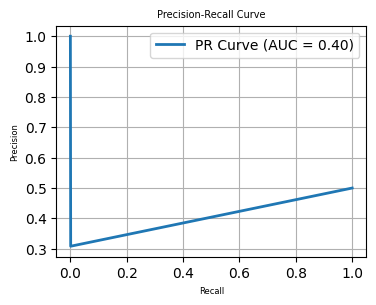

In [15]:
plotting_PR_AUC(seq_model, val_loader)

# Promoter capture

In [16]:
BATCH_SIZE = 512
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])

In [17]:
task = "CapturePromoter"

train_dataset = StarrSeqDataset(task = task, split = "train",transform = train_transform)

val_dataset = StarrSeqDataset(task = task, split = "val",transform = val_test_transform) 

test_dataset = StarrSeqDataset(task = task, split = "test", transform = val_test_transform)

In [18]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [19]:
seq_len = len(train_dataset[0][0][0])
model = Simple_Classification_Net(seq_len = seq_len)

seq_model = LitModel_StarrSeq(model = model,
                           loss = torch.nn.BCEWithLogitsLoss(),
                           weight_decay = 1e-1, lr = 1e-2, print_each = 5)

In [20]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/nios/5Term/examples/lightning_logs/version_58/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | Simple_Classification_Net | 386 K  | train
1 | loss  | BCEWithLogitsLoss         | 0      | train
------------------------------------------------------------
386 K     Trainable params
0         Non-trainable params
386 K     Total params
1.547     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.50
Recall (при пороге 0.5): 1.00
PR-AUC (correct): 0.50
PR-AUC: 0.75


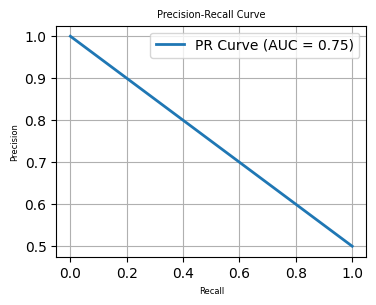

In [21]:
plotting_PR_AUC(seq_model, test_loader)

# Genome enhancer

In [22]:
BATCH_SIZE = 1024
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])

In [23]:
task = "GenomicEnhancer"

train_dataset = StarrSeqDataset(task = task, split = "train",transform = train_transform)

val_dataset = StarrSeqDataset(task = task, split = "val",transform = val_test_transform) 

test_dataset = StarrSeqDataset(task = task, split = "test", transform = val_test_transform)

In [24]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [25]:
seq_len = len(train_dataset[0][0][0])
model = Simple_Classification_Net(seq_len = seq_len)

seq_model = LitModel_StarrSeq(model = model,
                           loss = torch.nn.BCEWithLogitsLoss(),
                           weight_decay = 1e-1, lr = 1e-2, print_each = 5)

In [26]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/nios/5Term/examples/lightning_logs/version_58/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | Simple_Classification_Net | 540 K  | train
1 | loss  | BCEWithLogitsLoss         | 0      | train
------------------------------------------------------------
540 K     Trainable params
0         Non-trainable params
540 K     Total params
2.162     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.47
Recall (при пороге 0.5): 1.00
PR-AUC (correct): 0.47
PR-AUC: 0.73


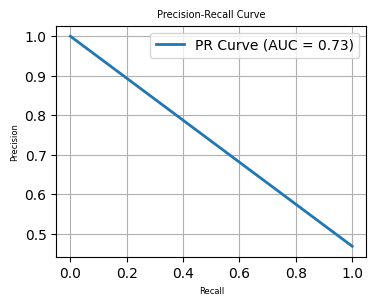

In [27]:
plotting_PR_AUC(seq_model, test_loader)

# ATACseq

In [28]:
BATCH_SIZE = 2048
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])

In [29]:
task = "atacseq"

train_dataset = StarrSeqDataset(task = task, split = "train",transform = train_transform)

val_dataset = StarrSeqDataset(task = task, split = "val",transform = val_test_transform) 

test_dataset = StarrSeqDataset(task = task, split = "test", transform = val_test_transform)

In [30]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [31]:
seq_len = len(train_dataset[0][0][0])
model = Simple_Classification_Net(seq_len = seq_len)

seq_model = LitModel_StarrSeq(model = model,
                           loss = torch.nn.BCEWithLogitsLoss(),
                           weight_decay = 1e-1, lr = 1e-2, print_each = 5)

In [32]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/nios/5Term/examples/lightning_logs/version_58/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | Simple_Classification_Net | 540 K  | train
1 | loss  | BCEWithLogitsLoss         | 0      | train
------------------------------------------------------------
540 K     Trainable params
0         Non-trainable params
540 K     Total params
2.162     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.51
Recall (при пороге 0.5): 1.00
PR-AUC (correct): 0.51
PR-AUC: 0.76


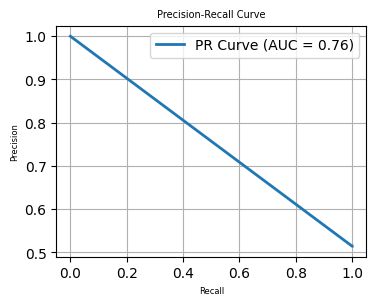

In [33]:
plotting_PR_AUC(seq_model, test_loader)

# Binary task

In [5]:
BATCH_SIZE = 1024
NUM_WORKERS = 103

train_transform = t.Compose([
    t.Seq2Tensor(),
    #t.ReverseComplement(0.5)
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])

In [6]:
binary_train = ["promoter_from_input", "enhancer_permutated", "enhancer_from_input"]
task = tasks[6]

train_dataset = StarrSeqDataset(task = task, binary_class = None, split = "train", transform = train_transform)

val_dataset = StarrSeqDataset(task = task, split = "val", transform = val_test_transform) 

test_dataset = StarrSeqDataset(task = task, split = "test", transform = val_test_transform)

using train
using val
using test


In [7]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [8]:
seq_len = len(train_dataset[0][0]["seq_enh"][0])
model = Simple_Classification_for_binary_Net()

seq_model = LitModel_StarrSeqBinary(model = model, seq_len = seq_len, batch_size = BATCH_SIZE,
                           loss = torch.nn.BCEWithLogitsLoss(),
                           weight_decay = 1e-1, lr = 1e-2, print_each = 5)

In [9]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-04-10 17:42:23.750206: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 17:42:23.764325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744296143.779317 3006892 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin 

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=1` reached.


In [10]:
import sklearn
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt
def plotting_PR_AUC_binary(seq_model, test_loader):
    act = nn.Sigmoid()
    
    #get predicted values
    y_preds = trainer.predict(seq_model, test_loader)

    y_preds = torch.concat(y_preds)
    
    targets = []
    for i, batch in enumerate(test_loader):
        x, y = batch
        targets.append(y)
    targets = torch.tensor(torch.concat(targets).cpu().numpy())
    y_preds = act(y_preds)
    
    threshold = 0.5 
    y_true = targets.cpu().numpy()
    y_pred = (y_preds.numpy() >= threshold).astype(int)
    y_scores = y_preds.numpy()
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    prauc = average_precision_score(y_true, y_scores)
    
    print(f"Precision (при пороге {threshold}): {precision:.2f}")
    print(f"Recall (при пороге {threshold}): {recall:.2f}")
    print(f"PR-AUC (correct): {prauc:.2f}")
    
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_scores)
    
    pr_auc = auc(recall_vals, precision_vals)
    
    print(f"PR-AUC: {pr_auc:.2f}")
    
    plt.figure(figsize=(4,3))
    plt.plot(recall_vals, precision_vals, label=f'PR Curve (AUC = {pr_auc:.2f})', linewidth=2)
    plt.xlabel('Recall', fontsize=6)
    plt.ylabel('Precision', fontsize=6)
    plt.title('Precision-Recall Curve', fontsize=7)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision (при пороге 0.5): 0.00
Recall (при пороге 0.5): 0.00
PR-AUC (correct): 0.50
PR-AUC: 0.75


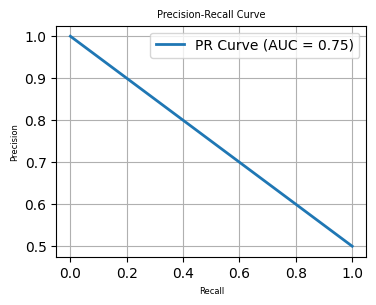

In [11]:
plotting_PR_AUC_binary(seq_model, test_loader)